# Two-qubit gate layer learning

This notebook shows a simplified procedure for learning the noise assocaited with a layer of two-qubits gates. Here, the twirl is not implemented, and instead a Pauli noise model is used directly. The measurements are made individually. For the sparse model, this would still scale linearly with the number of qubits, but van den Berg et Al. shows that the efficiency of the process can be further improved through the use of simultaneous measurements. This is implemented in a later notebook but omitted here for simplicity.

In [4]:
from qiskit.quantum_info import Operator, Pauli, PTM, pauli_basis
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel, pauli_error

import numpy as np
from random import choices, random
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

plt.style.use("ggplot")

When the layer consists of self-adjoint two-qubit Clifford gates, the pauli terms will appear in pairs. The following cell find the paulis that are conjugate under an application of the noisy layer. This will be replaced by `pauli.evolve(clifford)` in later versions.

In [6]:
n=2
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

def get_name(pauli_op):
    try:
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

def conjugate(pauli, cliffordop):
    return get_name(cliffordop.compose(Operator(Pauli(pauli).to_matrix())).compose(cliffordop))

In [7]:
p_group = pauli_basis(n, pauli_list = True).to_labels()
p_group_permuted = [conjugate(p, Operator(CXGate())) for p in p_group]
pairs = list(zip(p_group, p_group_permuted))
print(pairs)

[('II', 'II'), ('IX', 'XX'), ('IY', 'XY'), ('IZ', 'IZ'), ('XI', 'XI'), ('XX', 'IX'), ('XY', 'IY'), ('XZ', 'XZ'), ('YI', 'YZ'), ('YX', 'ZY'), ('YY', 'ZX'), ('YZ', 'YI'), ('ZI', 'ZZ'), ('ZX', 'YY'), ('ZY', 'YX'), ('ZZ', 'ZI')]


Text(0, 0.5, '10x(1-f)')

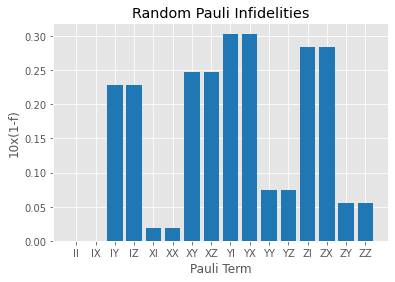

In [12]:
errorgen = 4
errorops = choices(p_group, k=errorgen)
errorprobs = [random()*.1/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli.to_label()] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real, color = "tab:blue")

plt.title("Random Pauli Infidelities")
plt.xlabel("Pauli Term")
plt.ylabel("10x(1-f)")

In [13]:
#get the expectation value of a pauli operator after a run of a circuit, where a transformation
#into the computational basis has already been performed at the end of the circuit
def get_expectation(circuit, pauli_str, noise = True):
    circ = circuit.copy()
    circ.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    if noise:
        counts = execute(circ, backend, shots = SHOTS, noise_model = noise_model, basis_gates = noise_model.basis_gates, optimization_level=0).result().get_counts()
    else:
        counts = execute(circ, backend, shots = SHOTS).result().get_counts()
    total = 0
    for key in counts.keys():
        pauli_weight = [{"I":'0'}.get(p,'1') for p in pauli_str]
        total += (-1)**sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pauli_weight, key)])*counts[key]
    return total/SHOTS

#Implement the basic outline of the procedure, which consists of changing to the preparation basis,
#followed by a number of applications of the noisy layer, and then changing back to the measurement basis
def measure_circuit(pauli_prep, pauli_meas, depth):
    total = 0
    qc = QuantumCircuit(2)
    for i,p in enumerate(pauli_prep[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.h(i)
                qc.s(i)
    for i in range(depth):
        qc.cx(0,1)
    for i,p in enumerate(pauli_meas[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.sdg(i)
                qc.h(i)
    return qc 

The addition of the layer of self-adjoint clifford gates introduces the complication that some of the fidelities now appear in pairs. This next cell identifies those operators with weight two which are conjugate under application of the layer to a pauli operator of weight one.

In [15]:
single_pairs = set()
for p1, p2 in zip(p_group, p_group_permuted):
    if 'I' in p1 and not 'I' in p2:
        single_pairs.add((p2,p1))
    if 'I' in p2 and not 'I' in p1:
        single_pairs.add((p1,p2))
print(single_pairs)

{('YZ', 'YI'), ('XY', 'IY'), ('XX', 'IX'), ('ZZ', 'ZI')}


One measurement needs to be taken for each of these pairs to lift the degeneracy associated with the fidelity pair. The single measurements differ from the normal measurement procedure in that there are an odd number of applications of the noisy layer, and the preparation and measurement bases differ.

In [19]:
for double, single in single_pairs:
    circ = measure_circuit(double,double,1)
    print(single, "measured:",get_expectation(circ, single), "ideal:", real_errors[single]) #no spam, otherwise divide by single measurement

YI measured: 0.97076 ideal: (0.9696639315581543+0j)
IY measured: 0.97584 ideal: (0.977172543887425+0j)
IX measured: 1.0 ideal: (1+0j)
ZI measured: 0.97268 ideal: (0.9716055935821095+0j)


This next cell demonstrates that the fidelities measured by an exponential fit to an even number of applications of the noisy layer are indeed fidelity pairs. Below, the measured value is exhibited next to both the ideal value and the ideal pair value, and the measured value will agree more closely with the pair value. In addition, this is true whether there is an even or odd application of the noisy layer.

In [18]:
depths = [1,3,5,7,9,11,13]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, single))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(single, "real:", real_errors[single], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

YI real: (0.9696639315581543+0j) measured: 0.9808279117337403 pair: (0.9810112644645869+0j)
IY real: (0.977172543887425+0j) measured: 0.9756423262120315 pair: (0.9762012301303987+0j)
IX real: (1+0j) measured: 0.9990526746712856 pair: (0.9990286972735292+0j)
ZI real: (0.9716055935821095+0j) measured: 0.9829694528224434 pair: (0.9829530576412443+0j)


In [20]:
depths = [2,4,6,8,10,12,14]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, double))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(double, "real:", real_errors[double], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

YZ real: (0.9924913876707293+0j) measured: 0.981067024982668 pair: (0.9810112644645869+0j)
XY real: (0.9752308818634698+0j) measured: 0.9759614894197263 pair: (0.9762012301303987+0j)
XX real: (0.9980583379760448+0j) measured: 0.9989863973776559 pair: (0.9990286972735292+0j)
ZZ real: (0.9944330496946845+0j) measured: 0.9831945860908413 pair: (0.9829530576412443+0j)


## Measurement Procedure
The remainder of the notebook shows how the degeneracy-lifting single measurements can be combined with the double measurements to fully learn the fidelities in the model.

The pauli terms of weight two which are conjugate to other pauli terms of weight two are separated out. Since the support of the pauli term doesn't change after application of the layer, single-qubit gates can be inserted during benchmarking that change the Pauli terms back to the original, allowing them to be measured in a SPAM-free manner.

In [22]:
double_pairs = []
for p1, p2 in pairs:
    if not ("I" in p1 or "I" in p2 or (p2,p1) in double_pairs or p1 == p2):
        double_pairs.append((p1,p2))

print(double_pairs)

[('YX', 'ZY'), ('YY', 'ZX')]


In [23]:
#procedure for measurement using an even number of layer applications
def measure_double(pauli, pauli_pair, depth):
    qc = QuantumCircuit(n)

    #basis change gates
    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.h(i)
                qc.s(i)

    qc.barrier()

    #noisy layer applciations 
    for j in range(depth):
        #single qubit gates for changing pauli pair
        for i,p in enumerate(zip(pauli[::-1], pauli_pair[::-1])):
            match p:
                case ("X","Y"):
                    qc.s(i)
                case ("X", "Z"):
                    qc.h(i)
                case ("Y", "X"):
                    qc.sdg(i)
                case ("Y", "Z"):
                    qc.sdg(i)
                    qc.h(i)
                case ("Z", "X"):
                    qc.h(i)
                case ("Z", "Y"):
                    qc.h(i)
                    qc.s(i)
        #noisy layer
        qc.cx(0,1) 

        qc.barrier()

    #change back to computational basis 
    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.sdg(i)
                qc.h(i)

    return qc

Some pauli terms require degeneracy-lifting measurements with a single depth. This is shown in the following method:

In [25]:
#procedure for degeneracy-lifting measurements
def measure_single(single, double):
    #measure first at depth zero to obtain estimate of SPAM errors
    circ = measure_double(single, single, 0)
    result0 = get_expectation(circ, single)
    #then measure at depth one to obtain fidelity and SPAM estimate
    circ = measure_double(double, single, 1)
    result1 = get_expectation(circ, single)
    
    return result1/result0

The next cell separates the pauli terms into three categories:
* easy: the pauli term is conjugate to itself
* medium: the pauli term is conjugate to another term of equal weight, requiring single-qubit gates
* hard: the pauli term is conjugate to another pauli term in the model, requiring a degeneracy-lifting measurement.

In [28]:
easy_set = set(p1 for (p1, p2) in pairs if p1==p2)
medium_set = set([(p1,p2) for (p1,p2) in pairs if not ("I" in p1 or "I" in p2) and p1 != p2])
hard_set = set([(p1, p2) for (p1, p2) in pairs if (not "I" in p1 and "I" in p2) and not p2 in easy_set])

## Putting it together

Putting the procedure together by measuring the fidelities in the easy set directly, choosing the appropriate single-qubit gates to measure the fidelitites in the medium set, and completing the model with the necessary degeneracy-lifing measurements.

In [29]:
measured_errors = {}
depths = [2,4,6,8,10,12] #has to be even

for p in easy_set:
    results = []
    for d in depths:
        circ = measure_double(p, p, d)
        results.append(get_expectation(circ, p))
    popt, pcov = curve_fit(expfit, depths, results)
    measured_errors[p] = np.exp(-popt[1])

/usr/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [30]:
for p1, p2 in medium_set.union(hard_set):
    results = []
    for d in depths:
        circ = measure_double(p1, p2, d)
        results.append(get_expectation(circ, p1))
    popt, pcov = curve_fit(expfit, depths, results) 
    measured_errors[p1] = np.exp(-popt[1])

In [31]:
for double, single in hard_set:
    single_err = measure_single(single, double)
    measured_errors[single] = single_err
    measured_errors[double] = measured_errors[double]**2/single_err

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


Text(0, 0.5, '10x(1-f)')

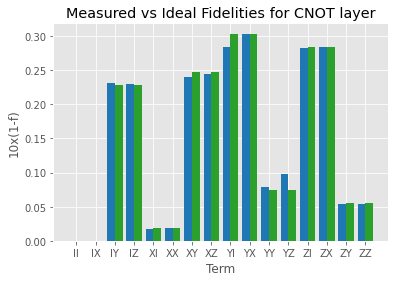

In [34]:
labels = []
real_bar = []
measured_bar = []
for pauli in pauli_basis(2, pauli_list = True).to_labels():
    labels.append(pauli)
    real_bar.append(10*(1-real_errors[pauli]))
    measured_bar.append(10*(1-measured_errors[pauli]))

ax = np.arange(len(labels))
plt.bar(ax+.2, real_bar, .4, color='tab:green')
plt.bar(ax-.2, measured_bar, .4, color='tab:blue')
plt.xticks(ax, labels);
plt.title("Measured vs Ideal Fidelities for CNOT layer")
plt.xlabel("Term")
plt.ylabel("10x(1-f)")